# Store Sales - Time Series Forecasting
---

Using machine learning to predict grocery sales

In this notebook we will be solving the problem from the competiton: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting) from [Kaggle](https://www.kaggle.com/)

### Summary:
*   In this competition, you’ll use time-series forecasting to forecast store sales on data from **Corporación Favorita**, a large Ecuadorian-based grocery retailer.
    *   Specifically, you'll build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores.  
    You'll practice your machine learning skills with an approachable training dataset of dates, store, and item information, promotions, and unit sales.

* The evaluation metric for this competition is Root Mean Squared Logarithmic Error - RMSLE.

### File Descriptions and Data Field Information

#### `train.csv`
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

*   **store_nbr** identifies the store at which the products are sold.
*   **family** identifies the type of product sold.
*   **sales** gives the total sales for a product family at a particular store at a given date.  
    Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
*   **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

#### `test.csv`
The test data, having the same features as the training data.  
You will predict the target sales for the dates in this file.  
*   The dates in the test data are for the 15 days after the last date in the training data.

#### `sample_submission.csv`
*   A sample submission file in the correct format.

#### `stores.csv`
Store metadata, including city, state, type, and cluster.
*   **cluster** is a grouping of similar stores.

#### `oil.csv`
Daily oil price.  
Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### `holidays_events.csv`
Holidays and Events, with metadata  


### NOTES:
Pay special attention to the transferred column.  
*   A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government.

*   A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is **Transfer**.  
    *   For example, the holiday ***Independencia de Guayaquil*** was transferred from **2012-10-09** to **2012-10-12**, which means it was celebrated on **2012-10-12**.  

*   Days that are type **Bridge** are extra days that are added to a holiday (e.g., to extend the break across a long weekend).  

*   These are frequently made up by the type **Work Day** which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the **Bridge**.

*   Additional holidays are days added a regular calendar holiday, for example, as typically happens around **Christmas** (making Christmas Eve a holiday).

*   Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. **Supermarket sales could be affected by this.**

*   A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

# Importing Libraries:
---

To keep the code more concise and undestandable, here I will be listing all of the libraries used during the code

In [1]:
# System libraries
import sys
import zipfile
import pathlib
import os
import dotenv

# Data Manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

# Statistical Analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.feature_selection import mutual_info_regression

# Modelling
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pickle

# Warning filter
import warnings
warnings.filterwarnings("ignore")

## Loading Data:

In [2]:
pathlib.Path("data").mkdir(parents=True, exist_ok=True)

file_path = pathlib.Path("data/train.csv")
if not file_path.is_file():
    with zipfile.ZipFile("./store-sales-time-series-forecasting.zip", 'r') as zf:
        zf.extractall("./data/")

## Reading all files:

In [3]:
# Assign all files to a variable:

# sales
sales = pd.read_csv('./data/train.csv', dtype={'date':'str'}, parse_dates=['date'])

# stores
stores = pd.read_csv('./data/stores.csv').rename(columns={'type':'store_type'})

# oil prices
oil = pd.read_csv('./data/oil.csv', dtype={'date':'str'}, parse_dates=['date']).rename(columns={'dcoilwtico':'oil_price'})

# holiday events
holidays = pd.read_csv('./data/holidays_events.csv', dtype={'date':'str'}, parse_dates=['date']).rename(columns={'type':'holiday_type'})

# transactions
transactions = pd.read_csv('./data/transactions.csv', dtype={'date':'str'}, parse_dates=['date'])

# train set
train = sales.copy()

# test set
test = pd.read_csv('./data/test.csv', dtype={'date':'str'}, parse_dates=['date'])

# Exploratory Data Analysis (EDA)
---

In [4]:
# printing the head of each file
files = {'sales':sales,
         'stores':stores,
         'oil':oil,
         'holidays':holidays,
         'transactions':transactions}

for filename, data in files.items():
    print(f'FILE: {filename}')
    display(data.head())
    print()

FILE: sales


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0



FILE: stores


,store_nbr,city,state,store_type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4



FILE: oil


,date,oil_price
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20



FILE: holidays


,date,holiday_type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False



FILE: transactions


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


## 1. Undestanding the Datasets

### 1.1 Shape of the datasets
---

In [5]:
# train
print('Train:', train.shape)

# test
print('Test:', test.shape, end='\n\n')

# stores
print('Stores:', stores.shape)

# transactions
print('Transactions:', transactions.shape)

# holidays
print('Holidays:', holidays.shape)

# oil price
print('Oil:', oil.shape)

Train: (3000888, 6)
Test: (28512, 5)

Stores: (54, 5)
Transactions: (83488, 3)
Holidays: (350, 6)
Oil: (1218, 2)


The train dataset contains 3,000,888 (99.06% of instances) rows and 6 columns while the test dataset contains 28,512 (00.94% of instances) rows and 5 columns.  


The train dataset is **significantly** larger than the test dataset in terms of the number of rows. This is expected (specially in forecasting problems) as the train dataset is usually larger to provide sufficient data for model training.

### 1.2 Features (columns) Information
---

In [6]:
def show_features_info(name:str, df:pd.DataFrame):
    print(f'Features Informations for: {name}', end='\n\n')
    df.info()

In [7]:
dataframes = {'train':train,
              'stores':stores,
              'oil':oil,
              'holidays':holidays,
              'transactions':transactions,
              'test':test}

for name, df in dataframes.items():
    show_features_info(name, df)
    print(end='\n\n')

Features Informations for: train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


Features Informations for: stores

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   store_nbr   54 non-null     int64 
 1   city        54 non-null     object
 2   state       54 non-null     object
 3   store_type  54 non-null     object
 4   cluster     54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


Features Informations for: oil

<cla

The train dataset contains **3,000,888** entries and 6 columns: 'id', 'date', 'store_nbr', 'family', 'sales', and 'onpromotion'.

The test dataset contains **28,512** entries and 5 columns: 'id', 'date', 'store_nbr', 'family', and 'onpromotion'.

As expected, the test dataset does not have the "**sales**" column. This column is not needed because 'sales' is the feature we want to predict. The goal is to use the trained model to predict or forecast the sales in the test data based on the other available features.

*   The Holiday Events Dataset:  
The dataset contains 350 entries and 6 columns: 'date', 'type', 'locale', 'locale_name', 'description', and 'transferred'.
The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.


*   The Oil Dataset:  
The dataset contains 1,218 entries has 2 columns: 'date' and 'oil_price'.
The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.
The 'oil_price' column has 1,175 non-null values, indicating that there are some missing values in this column.


*   The Stores dataset:  
The dataset contains 54 entries and 5 columns: 'store_nbr', 'city', 'state', 'type', and 'cluster'.


*   The Transactions dataset:  
The dataset contains 83,488 entries and 3 columns: 'date', 'store_nbr', and 'transactions'.
The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.

Since we did `pd.read_csv(..., dtype={'date':'str'}, parse_dates=['date'], ...)`, we already have the 'date' column in all datasets with the same type: `datetime64[ns]`

### 1.3 Summary Statistics
---

In [8]:
def summary_statistics(name:str, df:pd.DataFrame):
    if df.select_dtypes(include=[np.int64, np.int32, np.float64, np.float32]).shape[1] > 0:
        print(f'Features Statistics for Numerical Data in: {name}', end='\n\n')
        display(df.select_dtypes(include=[np.int64, np.int32, np.float64, np.float32]).describe().T)

In [9]:
dataframes = {'train':train,
              'stores':stores,
              'oil':oil,
              'holidays':holidays,
              'transactions':transactions}

for name, df in dataframes.items():
    summary_statistics(name, df)
    print(end='\n\n')

Features Statistics for Numerical Data in: train



,count,mean,std,min,25%,50%,75%,max
id,3000888.0,1.500444e+06,866281.891642,0.0,750221.75,1500443.5,2.250665e+06,3000887.0
store_nbr,3000888.0,2.750000e+01,15.585787,1.0,14.00,27.5,4.100000e+01,54.0
sales,3000888.0,3.577757e+02,1101.997721,0.0,0.00,11.0,1.958473e+02,124717.0
onpromotion,3000888.0,2.602770e+00,12.218882,0.0,0.00,0.0,0.000000e+00,741.0




Features Statistics for Numerical Data in: stores



,count,mean,std,min,25%,50%,75%,max
store_nbr,54.0,27.500000,15.732133,1.0,14.25,27.5,40.75,54.0
cluster,54.0,8.481481,4.693395,1.0,4.00,8.5,13.00,17.0




Features Statistics for Numerical Data in: oil



,count,mean,std,min,25%,50%,75%,max
oil_price,1175.0,67.714366,25.630476,26.19,46.405,53.19,95.66,110.62






Features Statistics for Numerical Data in: transactions



,count,mean,std,min,25%,50%,75%,max
store_nbr,83488.0,26.939237,15.608204,1.0,13.0,27.0,40.0,54.0
transactions,83488.0,1694.602158,963.286644,5.0,1046.0,1393.0,2079.0,8359.0


As you can see, the **stores** and **holidays** datasets don't have numerical data:

* Stores:

    |Column         |Type          |
    |---------------|--------------|
    |store_nbr      |object        |
    |city           |object        |
    |state          |object        |        
    |type           |object        |        
    |cluster        |object        |

<br>

* Holidays:

    |Column         |Type          |
    |---------------|--------------|
    |date           |datetime64[ns]|
    |type           |object        |
    |locale         |object        |        
    |locale_name    |object        |        
    |description    |object        |      
    |transferred    |bool          |

For the **test** set, we are not going to summarize it, just show the `dtypes`, since we weren't suppose to look at it!

* Test:

    |Column         |Type          |
    |---------------|--------------|
    |id             |int64         |
    |date           |datetime64[ns]|
    |store_nbr      |int64         |
    |family         |object        |
    |onpromotion    |int64         |

### 1.4 Missing Values
---

In [10]:
def show_missing(name:str, df:pd.DataFrame|pd.Series):
    print(f'Missing data for: {name}', end='\n')
    display(df.isnull().sum())
    print("===" * 10)

In [11]:
dataframes = {'train':train,
              'stores':stores,
              'oil':oil,
              'holidays':holidays,
              'transactions':transactions,
              'test':test}

for name, df in dataframes.items():
    show_missing(name, df)
    print(end='\n\n')

Missing data for: train


id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64



Missing data for: stores


store_nbr     0
city          0
state         0
store_type    0
cluster       0
dtype: int64



Missing data for: oil


date          0
oil_price    43
dtype: int64



Missing data for: holidays


date            0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dtype: int64



Missing data for: transactions


date            0
store_nbr       0
transactions    0
dtype: int64



Missing data for: test


id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

As we can see, the only dataframe that has missing data is the `oil`, so let's focus in this dataset.

In [12]:
# Visualizing the 'oil_price' column to Identify a Strategy for Handling Missing Values
fig = px.line(oil, x='date', y='oil_price')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

As shown above, the missing data occurs randomly on specific days, not on consecutive days. In this case we will use the backfill strategy.

In [13]:
# Defining first and last date
first_date = oil['date'].min()
last_date = oil['date'].max()

# Creating a DatetimeIndex with all dates between start and end, inclusive.
all_dates = pd.date_range(start=first_date, end=last_date)

# Checking in the training set if all dates are present.
missing_dates = all_dates[~all_dates.isin(oil['date'].unique())]
if len(missing_dates) == 0:
    print("There is no missing data. The dataset is complete!")
else:
    print("There is missing data in the dataset:")
    print("Missing Days: ", missing_dates.shape[0])

There is missing data in the dataset:
Missing Days:  486


In [14]:
# Transform the DatetimeIndex of the missing dates in a pandas DataFrame with pd.DataFrame
missing_dates = pd.DataFrame({'date':pd.Index(missing_dates, dtype='datetime64[ns]')})

# Concatenating this dates to the main training set
oil = pd.concat([oil, missing_dates], axis=0, ignore_index=True).sort_values(by='date', ascending=True)
oil

,date,oil_price
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
1218,2013-01-05,NaN
...,...,...
1703,2017-08-27,NaN
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [15]:
# Using the bfill (backfill) strategy
oil['oil_price'] = oil['oil_price'].bfill()
oil.isnull().sum()

date         0
oil_price    0
dtype: int64

In [16]:
# Visualizing the 'oil_price' column to Identify a Strategy for Handling Missing Values
fig = px.line(oil, x='date', y='oil_price')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### 1.5 Data Completeness
---

Let's look at the training set and see if all dates between the first and last dates are within the dataset (*data completeness*):

In [17]:
# Defining first and last date
first_date = train['date'].min()
last_date = train['date'].max()

# Creating a DatetimeIndex with all dates between start and end, inclusive.
all_dates = pd.date_range(start=first_date, end=last_date)

# Checking in the training set if all dates are present.
missing_dates = all_dates[~all_dates.isin(train['date'].unique())]
if len(missing_dates) == 0:
    print("There is no missing data. The dataset is complete!")
else:
    print("There is missing data in the dataset:")
    for i in missing_dates:
        print("\t", i.date())


There is missing data in the dataset:
	 2013-12-25
	 2014-12-25
	 2015-12-25
	 2016-12-25


Let input the missing dates in our train dataset, so it can be complete.

In [18]:
# Transform the DatetimeIndex of the missing dates in a pandas DataFrame with pd.DataFrame
missing_dates = pd.DataFrame({'date':pd.Index(missing_dates, dtype='datetime64[ns]')})

# Concatenating this dates to the main training set
train = pd.concat([train, missing_dates], ignore_index=True)

In [19]:
missing_dates = all_dates[~all_dates.isin(train['date'].unique())]
if len(missing_dates) == 0:
    print("There is no missing data. The dataset is complete!")
else:
    print("There is missing data in the dataset:")
    for i in missing_dates:
        print("\t", i.date())

There is no missing data. The dataset is complete!


### 1.6 Merging Datasets

Now we will merge all datasets to the training dataset

### 1.6.1. Segregating Holidays Dataset
---

In [20]:
# Removing holidays that were transferred or that happened on weekends
useless_days = (holidays['transferred'] == True) | (holidays['holiday_type'] == 'Work Day')
tHolidays = holidays.drop(holidays[useless_days].index)
tHolidays = tHolidays.drop(['holiday_type', 'description', 'transferred'], axis=1)
tHolidays['holiday'] = 1
tHolidays = tHolidays.drop(tHolidays[tHolidays['date'].duplicated()].index)

# Splitting holidays by 'locale' -> Local, Regional, National
local_holidays = tHolidays[tHolidays['locale'] == 'Local']
regional_holidays = tHolidays[tHolidays['locale'] == 'Regional']
national_holidays = tHolidays[tHolidays['locale'] == 'National'].drop(['locale', 'locale_name'], axis=1)

### 1.6.2. Merging All Datasets into One
---

In [21]:
# Merging with columns ('store_nbr' and 'date') or only ('date') in the datasets using the merge() function with how= 'inner' or 'left', depending.

# stores -> train
merged = pd.merge(left=train, right=stores, on='store_nbr', how='inner')

# transactions -> train
merged = pd.merge(left=merged, right=transactions, on=['date', 'store_nbr'], how='left').fillna(0)

# national_holidays -> train
for date in national_holidays['date']:
    merged.loc[merged['date'] == date, 'holiday'] = 1

# regional_holidays -> train
for date, state in zip(regional_holidays['date'], regional_holidays['locale_name']):
    merged.loc[(merged['date'] == date) & (merged['state'] == state), 'holiday'] = 1

# local_holidays -> train
for date, city in zip(local_holidays['date'], local_holidays['locale_name']):
    merged.loc[(merged['date'] == date) & (merged['city'] == city), 'holiday'] = 1

# Filling other days of 'holiday' feature with 0
merged['holiday'] = merged['holiday'].fillna(0)

# oil -> train
merged = pd.merge(left=merged, right=oil, on='date', how='left')

# View the first five rows of the merged dataset
merged.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday,oil_price
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,0.0,1.0,93.14
1,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,0.0,1.0,93.14
2,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0,Quito,Pichincha,D,13,0.0,1.0,93.14
3,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13,0.0,1.0,93.14
4,4.0,2013-01-01,1.0,BOOKS,0.0,0.0,Quito,Pichincha,D,13,0.0,1.0,93.14


#### 1.6.2.1 When `inner` or `left` Merge
---

**Inner Join** (`pd.merge(..., how='inner')`):

An inner merge type retains only the rows with matching values in the specified columns. In the context of time series forecasting, it allows us to merge datasets based on a common time index or timestamp. By performing an inner merge, we ensure that only the rows with corresponding timestamps in both datasets are included in the merged result.

With an inner merge, you eliminate any non-matching timestamps, which may not be useful for forecasting and could introduce inconsistencies in the data. By focusing on the intersection of the datasets, we can create a merged dataset that contains the necessary information for accurate time series forecasting.

<br>

**Left Join** (`pd.merge(..., how='left')`):

**Use Case**: When you want to keep all rows from the left dataset (e.g., train or test) and only match rows from the right dataset.
**Example**: Merging the train dataset with the holidays/events dataset on date, where you want to keep all sales records and only add holiday information when it exists.
**When to Use**: Typically used when merging auxiliary data (like store or product information) into the main dataset (like train or test), ensuring that no sales data is dropped.

### 1.6.3. Summarizing Merged Data
---

In [22]:
numerical_dtypes = [np.int32, np.int64, np.float32, np.float64]

# Summary of the merged dataset:
print('Summary:')
display(merged.select_dtypes(include=numerical_dtypes).describe().T)
print("===" * 15, end="\n\n")

# Checking for missing values:
print("Missing Data:")
display(merged.isnull().sum())

Summary:


,count,mean,std,min,25%,50%,75%,max
id,3000888.0,1.500444e+06,866281.891642,0.00,750221.75,1500443.50,2.250665e+06,3000887.00
store_nbr,3000888.0,2.750000e+01,15.585787,1.00,14.00,27.50,4.100000e+01,54.00
sales,3000888.0,3.577757e+02,1101.997721,0.00,0.00,11.00,1.958473e+02,124717.00
onpromotion,3000888.0,2.602770e+00,12.218882,0.00,0.00,0.00,0.000000e+00,741.00
cluster,3000888.0,8.481481e+00,4.649735,1.00,4.00,8.50,1.300000e+01,17.00
transactions,3000888.0,1.555808e+03,1033.367465,0.00,930.00,1331.00,1.976250e+03,8359.00
holiday,3000888.0,7.814287e-02,0.268396,0.00,0.00,0.00,0.000000e+00,1.00
oil_price,3000888.0,6.786216e+01,25.704229,26.19,46.32,53.19,9.580250e+01,110.62



Missing Data:


id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday         0
oil_price       0
dtype: int64

## 2. Univariate, Bivariate and Multivariate Analysis

### 2.1. Univariate Analysis

#### 2.1.1 'Sales' feature:
---

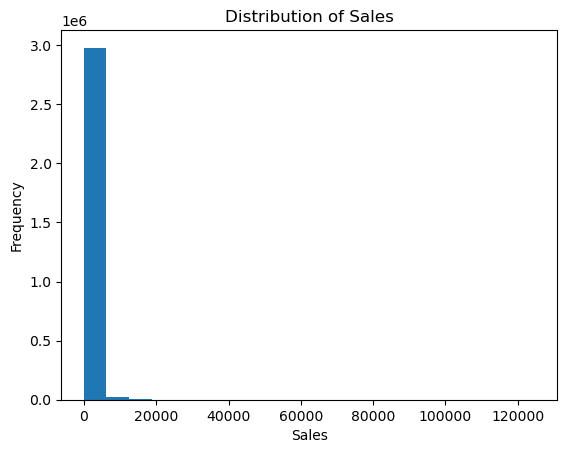

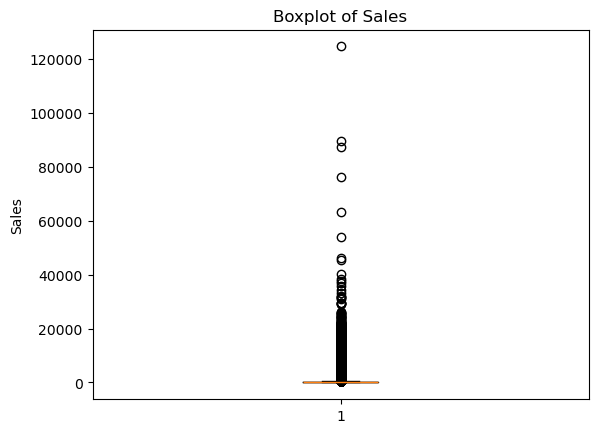

In [23]:
# Histogram
plt.hist(merged['sales'], bins=20)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.show()

# Boxplot
plt.boxplot(merged['sales'])
plt.ylabel('Sales')
plt.title('Boxplot of Sales')
plt.show()

The histogram and boxplot of the 'sales' feature provide insights into its distribution.  
The histogram shows the frequency distribution of sales values. It reveals that the majority of sales fall within a specific range, represented by the peak in the histogram. However, there are also instances of higher sales values, leading to a right-skewed distribution.  

This skewness suggests that there are relatively fewer occurrences of very high sales, while the majority of sales are concentrated around lower values. The boxplot further confirms the presence of outliers in the data, as indicated by the points beyond the markers.

#### 2.1.2 'transactions' Feature:
---

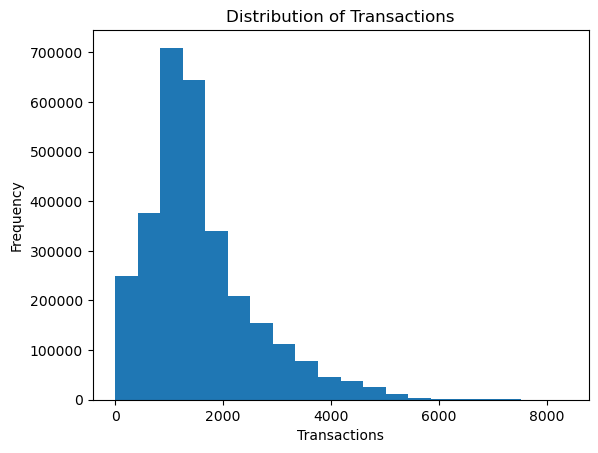

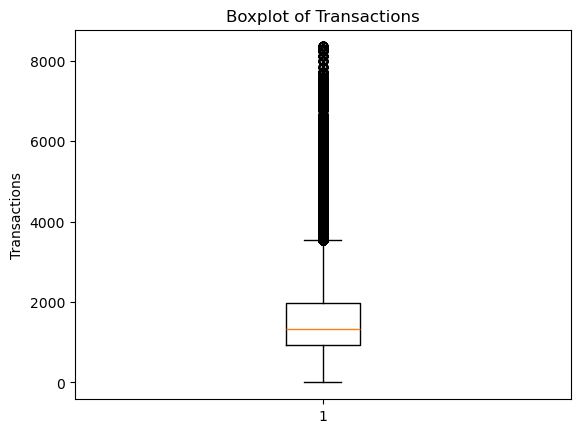

In [24]:
# Histogram
plt.hist(merged['transactions'], bins=20)
plt.xlabel('Transactions')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions')
plt.show()

# Boxplot
plt.boxplot(merged['transactions'])
plt.ylabel('Transactions')
plt.title('Boxplot of Transactions')
plt.show()

This histogram provides insights into the distribution of transactions in the dataset.  
The shape of the histogram indicates that the majority of transactions fall into a specific range, which is evident from the high frequency observed on the left side of the histogram. As the transactions increase, the frequency gradually decreases, forming a right-skewed distribution. This suggests that there are relatively fewer instances of high transaction volumes.  

Overall, the histogram highlights the presence of a cluster of transactions with a lower frequency, indicating a pattern in the data.

#### 2.1.3 'oil_price' Feature:
---

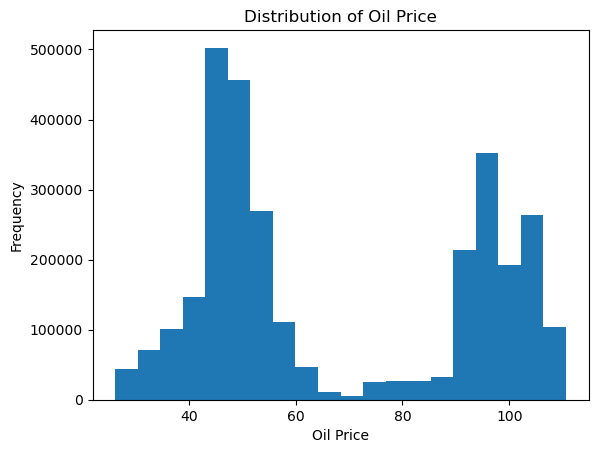

Text(0.5, 1.0, 'Boxplot of Oil Price')

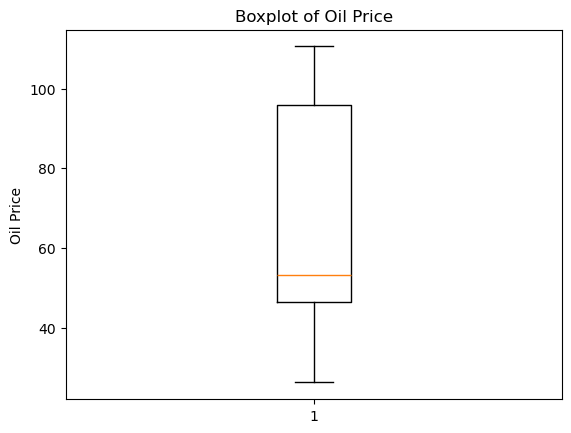

In [25]:
# Histogram
plt.hist(merged['oil_price'], bins=20)
plt.xlabel('Oil Price')
plt.ylabel('Frequency')
plt.title('Distribution of Oil Price')
plt.show()

# Boxplot
plt.boxplot(merged['oil_price'])
plt.ylabel('Oil Price')
plt.title('Boxplot of Oil Price')

The histogram and boxplot of the 'oil_price' feature reveal insights into its distribution.  
The histogram displays the frequency distribution of oil prices, indicating the number of occurrences for each price range.  

As we can see in the boxplot, there is no outlier in the 'oil_price' column, probably because oil is a commodity and its value is fixed at a certain margin.

#### 'onpromotion' Feature:
---

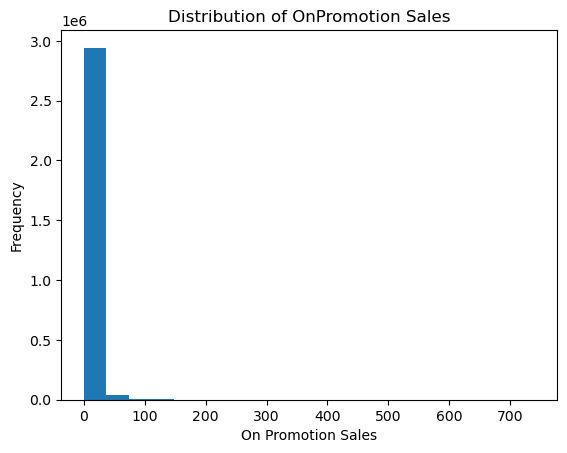

Text(0.5, 1.0, 'Boxplot of On Promotion Sales')

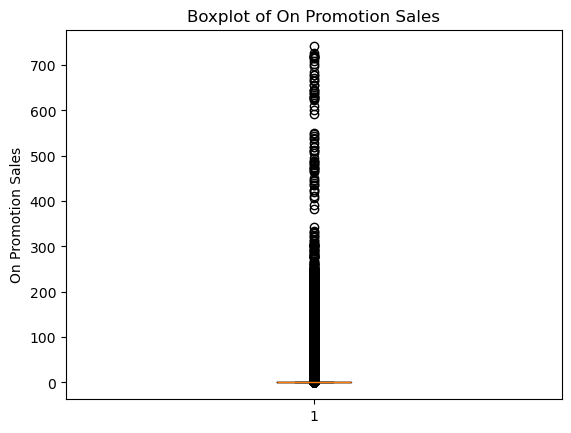

In [26]:
# Histogram
plt.hist(merged['onpromotion'], bins=20)
plt.xlabel('On Promotion Sales')
plt.ylabel('Frequency')
plt.title('Distribution of OnPromotion Sales')
plt.show()

# Boxplot
plt.boxplot(merged['onpromotion'])
plt.ylabel('On Promotion Sales')
plt.title('Boxplot of On Promotion Sales')

The histogram and boxplot of the 'onpromotion' feature provide insights into its distribution.  
The histogram shows the frequency distribution of onpromotion values. It reveals that the majority of sales fall within a specific range, represented by the peak in the histogram. However, like the 'sales' distribution, there are also instances of higher sales values, leading to a right-skewed distribution.  

This skewness suggests that there are relatively fewer occurrences of very high sales, while the majority of sales are concentrated around lower values. The boxplot further confirms the presence of outliers in the data, as indicated by the points beyond the markers.

### 2.2. Bivariate Analysis

#### 2.2.1 Trend of 'sales' Feature Over Time:
---

<a id='sales-over-time'></a>

In [27]:
# Group by date and calculate the total sales
daily_sales = merged.groupby('date')['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

The plot shows the trend of sales over time.  
From the graph, we can observe that the sales exhibit some variations and fluctuations over time. There are periods of both high and low sales, indicating potential seasonality or other factors affecting sales patterns.

Special attention for the end of December and begin of January of each year.

#### 2.2.2. Oil Price ('oil_price') Feature Over Time:
---

In [28]:
# Visualizing the 'oil_price' column to confirm if the trend is consistent.
fig = px.line(oil, x='date', y='oil_price')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

Observing the oil prices over time, we notice a clear trend. Oil prices experienced a significant drop towards the end of 2014 and have not bounced back since. Despite some fluctuations, they remain at the same level as they were at the start of 2015.  

Consequently, we might expect a notable change in store sales around late 2014. However, this isn’t immediately obvious when examining the unit sales data ([see 2.2.1](#sales-over-time)). While sales do seem to decline in early 2015, they actually increase in late 2014. Additionally, the drop in oil prices does not appear to affect sales, as shown in the sales plot. There is no correlation between the decrease in oil prices and sales, indicating that this data is not relevant for our modeling purposes and will be excluded.

### 2.2.3. Sales ('sales') by Store Type ('store_type')
---

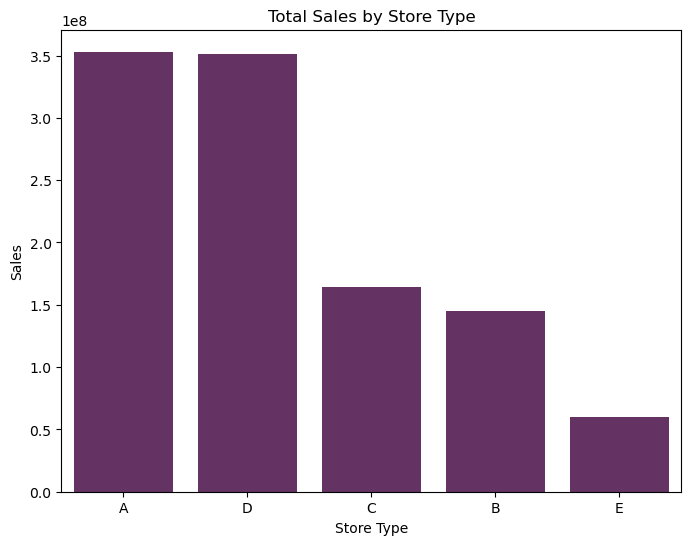

In [29]:
# Calculating the total sales by store_type:
store_type_sales = merged.groupby('store_type')['sales'].sum().sort_values(ascending=False)

# Create a bar plot with "flare_r" color palette for total sales
sns.set_palette("flare_r")
plt.figure(figsize=(8, 6))
sns.barplot(x=store_type_sales.index, y=store_type_sales.values)
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.title('Total Sales by Store Type')
plt.show()

The total sales amount varies across different store types.  
Store Type `D` has the highest total sales, indicating its significant contribution to the overall sales. Store Type `A` follows closely behind, demonstrating its substantial sales performance.  
Store Type C ranks third in terms of total sales, while Store Type B and Store Type E have lower sales amounts.

Understanding the variations in sales by store type helps identify the key drivers of revenue and highlights the importance of certain store types in driving overall sales.

### 2.2.4. Total Count per Store Type:
---

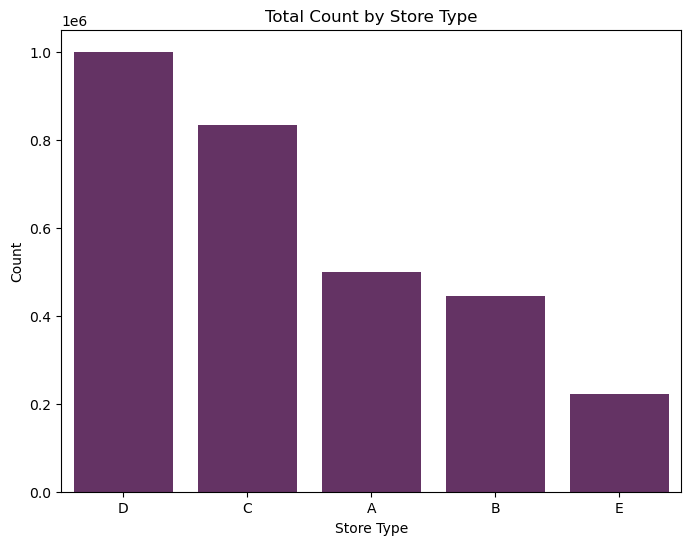

In [30]:
# Calculating the total sales by store_type:
store_type_counts = merged['store_type'].value_counts().sort_values(ascending=False)

# Create a bar plot with "flare_r" color palette for total count
sns.set_palette("flare_r")
plt.figure(figsize=(8, 6))
sns.barplot(x=store_type_counts.index, y=store_type_counts.values)
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.title('Total Count by Store Type')
plt.show()

The analysis of the total count of sales by store type provides insights into the sales performance and customer demand across different store types. Store Type D stands out with the highest count of sales, suggesting a strong customer base and popularity of products offered. Store Type C follows with a relatively lower count of sales, indicating a significant customer base as well.

On the other hand, Store Types A, B, and E have lower counts, suggesting potential areas for improvement or the need to address competition.

Special attention for Store Type `A`, since, as shown above, has the second highest total amount of sales but ranks third in the total count of sales in the set, problably indicating that a good portion of Store Type `A` sales were made in a single day!

### 2.2.5. Average Sales ('sales') by City
---

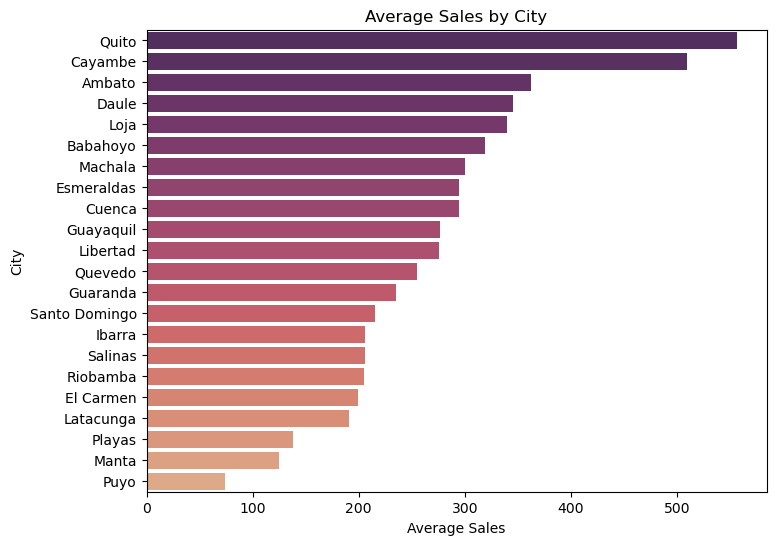

In [31]:
avg_sales_by_city = merged.groupby('city')['sales'].mean().sort_values(ascending=False)

# Create a bar plot with "flare_r" color palette for total sales
plt.figure(figsize=(8, 6))
sns.barplot(y=avg_sales_by_city.index, x=avg_sales_by_city.values, orient='h', palette='flare_r')
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales by City')
plt.show()

Quito has the highest number of stores, significantly surpassing other cities. Cayambe is the second most populated city in terms of stores followed by Ambato, Cuenca and Daule. Some cities have a moderate number of stores while others have a lower number of stores. Playas has the lowest number of average sales.

### 2.2.6. Sales ('sales') x Transactions ('transactions')
---

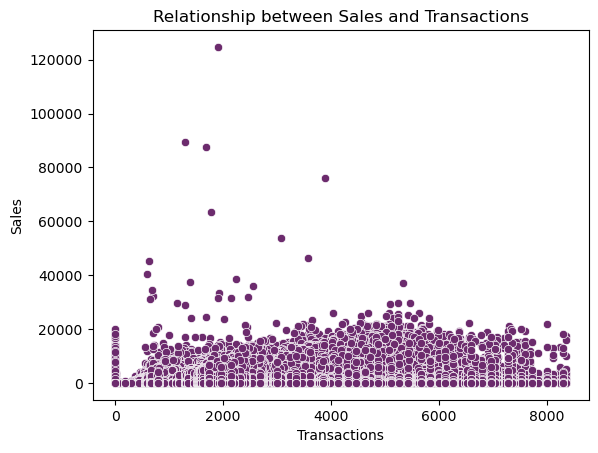

In [32]:
sns.scatterplot(data= merged, x='transactions', y='sales', palette='flare_r')
plt.xlabel('Transactions')
plt.ylabel('Sales')
plt.title('Relationship between Sales and Transactions')
plt.show()

The scatter plot illustrates the connection between sales and transactions within the dataset. Each point on the plot represents a specific instance with its corresponding sales and transaction values. Here are the main insights derived from the scatter plot:

Clustered Data Points: Most data points are concentrated in the lower sales region, forming a distinct cluster. This suggests that certain transaction volumes are consistently linked with specific sales levels, indicating a common sales pattern or trend at these transaction levels.

Outliers: Some data points deviate from the main cluster, appearing at higher sales levels for relatively lower transaction volumes or vice versa. These outliers represent exceptional cases where sales significantly differ from the typical pattern for a given number of transactions. Understanding these outliers can provide valuable insights into unusual sales scenarios or exceptional business activities.

In summary, the scatter plot offers valuable insights into the relationship between sales and transactions. The clustering of data points around specific sales and transaction levels reveals common patterns, while outliers highlight exceptional cases that merit further investigation. This analysis can help businesses make informed decisions and develop effective strategies to enhance sales performance.

<br><br>

### 2.3. Multivariate Analysis

#### 2.3.1. Correlation Matrix
---

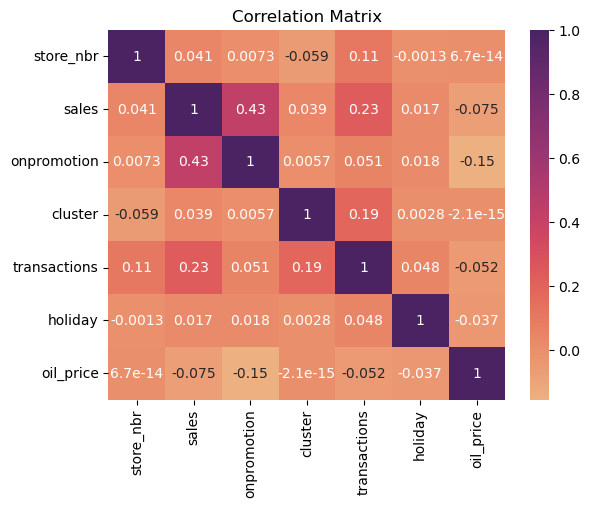

In [33]:
# Correlation matrix for numerical data
correlation_matrix = merged.select_dtypes(['int64', 'int32', 'float64', 'float32']).drop(columns=('id')).corr()

# Heatmap
sns.heatmap(correlation_matrix, cmap='flare', annot=True)
plt.title('Correlation Matrix')
plt.show()

Correlation values range from `-1` to `1`, where -1 indicates a perfect negative correlation, 1 indicates a perfect positive correlation, and 0 indicates no correlation. The table helps us understand the relationships between variables, providing valuable insights into their interactions. In this correlation matrix, we observe the correlations between different variables:

Sales x Transactions: There is a weak positive correlation of approximately `0.23` between “Sales” and “Transactions.” This suggests a slight positive relationship between the number of transactions and sales. It implies that as the number of transactions increases, sales tend to increase as well, although the correlation is not very strong.

Sales x Oil Price: There is a weak negative correlation of approximately `-0.075` between “Sales” and “Dcoilwito” (Oil Prices). This indicates a slight negative relationship between sales and oil prices. It suggests that as oil prices rise, sales tend to decrease slightly, though the correlation is not significant.

Sales x Onpromotion: There is a high positive correlation of approximately `0.43` between “sales” and “onpromotion”. This is to be expected, since "onpromotions" represents the number of sales that were made during a promotion. So, in general, as products are sold during a promotion, sales tend to rise.

Transactions x Oil Price: There is a very weak negative correlation of approximately `-0.052` between “Transactions” and “Dcoilwito” (Oil Prices). This suggests almost no relationship between the number of transactions and oil prices. It indicates that fluctuations in oil prices do not significantly impact the number of transactions.

Overall, the correlation values are relatively low, indicating that the relationships between these variables are not very strong. Other factors not considered in this correlation matrix may also influence sales, transactions, and oil prices. It’s essential to explore additional factors to gain a more comprehensive understanding of their impact on sales and transactions.

#### 2.3.2. Pair Plot
---

##### 2.3.2.1. What is a Pair Plot?
A pair plot is a type of data visualization that plots pairwise relationships between variables in a dataset. It helps you understand the interactions and correlations between different variables by displaying them in a grid of scatter plots and histograms.

##### 2.3.2.2. Key Features of `pairplot`:
1. **Grid of Plots**:
   - The `pairplot` function creates a grid where each variable in the dataset is plotted against every other variable.
   - The diagonal of the grid shows the univariate distribution of each variable, typically using histograms or kernel density estimates (KDE).

2. **Customization**:
   - You can customize the appearance of the plots using various parameters, such as `hue` to color-code data points based on a categorical variable, `kind` to specify the type of plot (e.g., scatter, KDE, or regression), and `diag_kind` to choose the type of plot for the diagonal.

3. **Highlighting Relationships**:
   - By visualizing all pairwise relationships, you can easily spot trends, correlations, and outliers in the data.
   - This is particularly useful for exploratory data analysis (EDA) to get a quick overview of the dataset.

##### 2.3.2.3. Benefits of Using `pairplot`:
- **Comprehensive Visualization**: Provides a comprehensive view of pairwise relationships in the dataset.
- **Easy Customization**: Offers various customization options to tailor the plots to your needs.
- **Quick Insights**: Helps quickly identify patterns, correlations, and outliers.

Overall, `pairplot` is a versatile and powerful tool for visualizing and exploring the relationships between variables in a dataset¹²³.

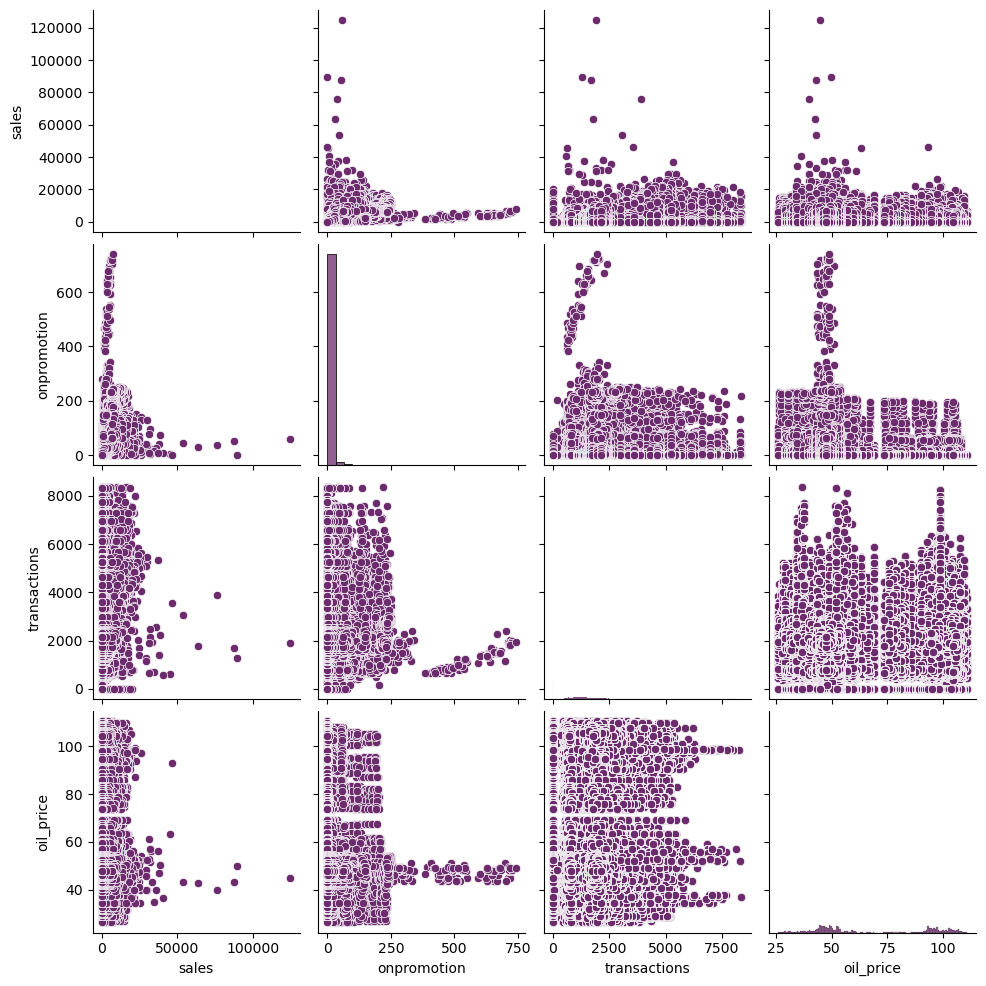

In [34]:
# Select features for pair plot
features_pairplot = ['sales', 'onpromotion', 'transactions', 'oil_price']

# Plot scatter plot matrix
sns.pairplot(data=merged[features_pairplot])
plt.show()

## 3. Statistical Tests

### 3.1. Stationarity
---

In statistics, stationarity refers to a property of a time series where its statistical characteristics, such as **mean, variance, and autocorrelation**, remain constant over time.  
This consistency makes it easier to model and predict the series.

For our project, we will be using the the Augmented Dickey-Fuller (ADF) test.  
The the Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series dataset is stationary or not.

O teste Augmented Dickey-Fuller (ADF) é um teste estatístico usado para determinar se uma série temporal é estacionária, ou seja, se suas propriedades estatísticas (como a média, a variância e a autocorrelação) são constantes ao longo do tempo. A estacionariedade é uma suposição importante em muitos modelos de séries temporais, como o ARIMA.

The ADF equation:

$
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \delta_2 \Delta y_{t-2} + \dots + \delta_p \Delta y_{t-p} + \epsilon_t
$

Where:
- $ \Delta y_t $ is the difference of the series $ y_t $,
- $ t $ is the time,
- $ \gamma y_{t-1} $ represents the term of the unitary root,
- $ \delta $ are the coefficients of the delayed difference,
- $ \epsilon_t $ is the error.

The hypothesis:
*   Null hypothesis (H0): The sales data is non-stationary.
*   Alternative hypothesis (H1): The sales data is stationary.

In [35]:
# Statistical Test of the 'sales' column
sales_data = merged[['date', 'sales']].groupby('date').sum()['sales']

# Perform ADF test using adfuller from statsmodels.tsa.stattools
result = adfuller(sales_data)

# Extract the test statistics and p-value from the result
test_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Print the test statistics and critical values
print(f"ADF Test Statistics: {test_statistic}")
print(f"P-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Check the p-value against a significance level (e.g., 0.05)
if p_value <= 0.05:
    print("Reject the null hypothesis: The sales data is stationary.")
else:
    print("Fail to reject the null hypothesis: The sales data is non-stationary.")

ADF Test Statistics: -2.6161957486048575
P-value: 0.08969592175787455
Critical Values:
   1%: -3.4342930672797065
   5%: -2.8632816397229064
   10%: -2.567697207194407
Fail to reject the null hypothesis: The sales data is non-stationary.


Based on the ADF test, the test statistics (-2.616) is lower than the critical values (10%) and higher in other confidence levels (1% and 5%).  
Additionally, the p-value is `0.0896`, which is higher than the significance level of `0.05`.

Since the `p-value` is more than `0.05`, we fail to reject the null hypothesis, indicating that the sales data is non-stationary.

### 3.2. Do Promotion has Impact on Sales?
---

To answer this, we will perform a two-sample **t-test** to compare sales between promotional (`'onpromotion' > 0.0`) and non-promotional (`'onpromotion' == 0.0`) periods.

The Hypothesis:
*   Null Hypothesis (H0): The promotional activities does not have a significant impact on store sales.
*   Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales.

In [36]:
# Extract the variables for the hypothesis test
promo_sales = merged[merged['onpromotion'] > 0.].groupby('date').sum()['sales']
non_promo_sales = merged[merged['onpromotion'] == 0.].groupby('date').sum()['sales']

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(promo_sales, non_promo_sales)

# Print the test result
print("Hypothesis Testing for Promotional Activities:")
print("-" * 50)
print("Test Statistic:", t_statistic)
print("P-value:", p_value)
print("=" * 50)
if p_value < 0.05:
    print("Reject the null hypothesis. Promotional activities have a significant impact on store sales.")
else:
    print("Fail to reject the null hypothesis. Promotional activities do not have a significant impact on store sales.")

Hypothesis Testing for Promotional Activities:
--------------------------------------------------
Test Statistic: 43.91841729702594
P-value: 1e-323
Reject the null hypothesis. Promotional activities have a significant impact on store sales.


Based on the hypothesis test, we obtained a very low p-value of almost `0.0`.  
This indicates strong evidence to reject the null hypothesis. Therefore, we can conclude that promotional activities have a significant impact on store sales.  

The test statistic of ~`208.4` also suggests a substantial difference in sales between promotional and non-promotional periods.  
These results support the notion that promotional activities play a crucial role in driving store sales.

### 3.3. Do the Earthquake (April 16, 2016) Impacted Sales?
---
To verify that, we will do a hypothesis test and a plot:

*   The Plot:
    *   Shows the sales before and after the earthquake

*   The Hypothesis:
    *   Null Hypothesis (H0): The earthquake does not had a significant impact on store sales.
    *   Alternative Hypothesis (H1): The earthquake had a significant impact on store sales.

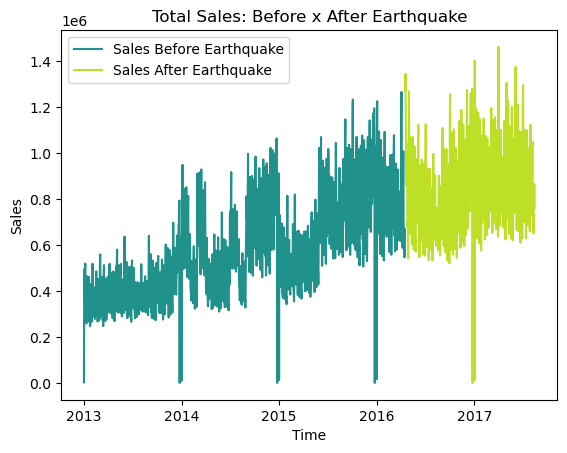

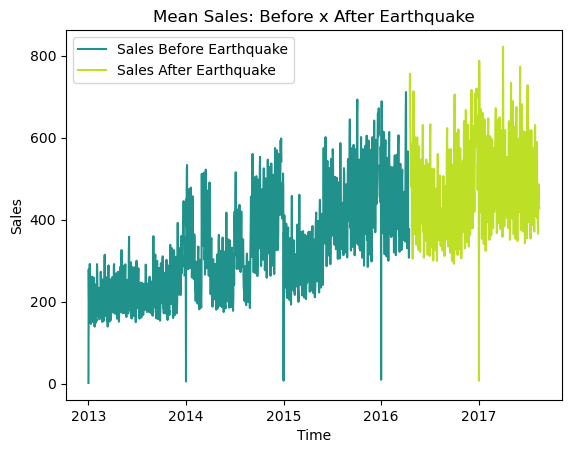

In [37]:
# Assign the variable earthquake_date to the date the earthquake took place (April 16, 2016)
earthquake = pd.to_datetime('2016-04-16')

# Creating total_sales, which is the sum of sales for each day
total_sales = train.groupby('date')['sales'].sum()
mean_sales = train.groupby('date')['sales'].mean()

# Filter the sales data before and after the earthquake
sum_sales_before_earthquake = total_sales[total_sales.index < earthquake]
sum_sales_after_earthquake = total_sales[total_sales.index > earthquake]
mean_sales_before_earthquake = mean_sales[mean_sales.index < earthquake]
mean_sales_after_earthquake = mean_sales[mean_sales.index > earthquake]

# Set the colormap to viridis
colormap = cm.get_cmap('viridis')

# Plot the sales before and after the earthquake
plt.plot(sum_sales_before_earthquake, color=colormap(0.5), label='Sales Before Earthquake')
plt.plot(sum_sales_after_earthquake, color=colormap(0.9), label='Sales After Earthquake')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.title('Total Sales: Before x After Earthquake')
plt.show()

plt.plot(mean_sales_before_earthquake, color=colormap(0.5), label='Sales Before Earthquake')
plt.plot(mean_sales_after_earthquake, color=colormap(0.9), label='Sales After Earthquake')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.title('Mean Sales: Before x After Earthquake')
plt.show()

In [38]:
from scipy.stats import ttest_rel
import datetime

day_30_before_earthquake = earthquake - datetime.timedelta(days=30)
day_30_after_earthquake = earthquake + datetime.timedelta(days=30)

mean_sales_before = mean_sales_before_earthquake[
    (mean_sales_before_earthquake.index < earthquake) & (mean_sales_before_earthquake.index >= day_30_before_earthquake)
    ]
mean_sales_after = mean_sales_after_earthquake[
    (mean_sales_after_earthquake.index > earthquake) & (mean_sales_after_earthquake.index <= day_30_after_earthquake)
    ]

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_rel(mean_sales_before, mean_sales_after)

# Print the test result
print("Hypothesis Testing for Earthquake impact on Sales:")
print("-" * 50)
print("Test Statistic:", t_statistic)
print("P-value:", p_value)
print("=" * 50)
if p_value < 0.05:
    print("Reject the null hypothesis. Earthquake had a significant impact on store sales.")
else:
    print("Fail to reject the null hypothesis. Earthquake do not had a significant impact on store sales.")

Hypothesis Testing for Earthquake impact on Sales:
--------------------------------------------------
Test Statistic: -2.393305618748859
P-value: 0.02339132355851932
Reject the null hypothesis. Earthquake had a significant impact on store sales.


Testing with 30 days sales before the earthquake and 30 days sales after the earthquake, we got the P-value of `0.02`, so we reject the null hypothesis. Earthquake had a significant impact on store sales.

### 3.4. Are Clusters of Stores Different in Sales?
---

For this type of analysis we will use ANOVA, since we have more than 2 groups (clusters), and we want to compare if their means are different.

To verify that, we will do a hypothesis test and a plot:

*   The Plot:
    *   Shows the sales per cluster.

*   The Hypothesis:
    *   Null Hypothesis (H0): The cluster have no impact on sales.
    *   Alternative Hypothesis (H1): The cluster have impact on sales.

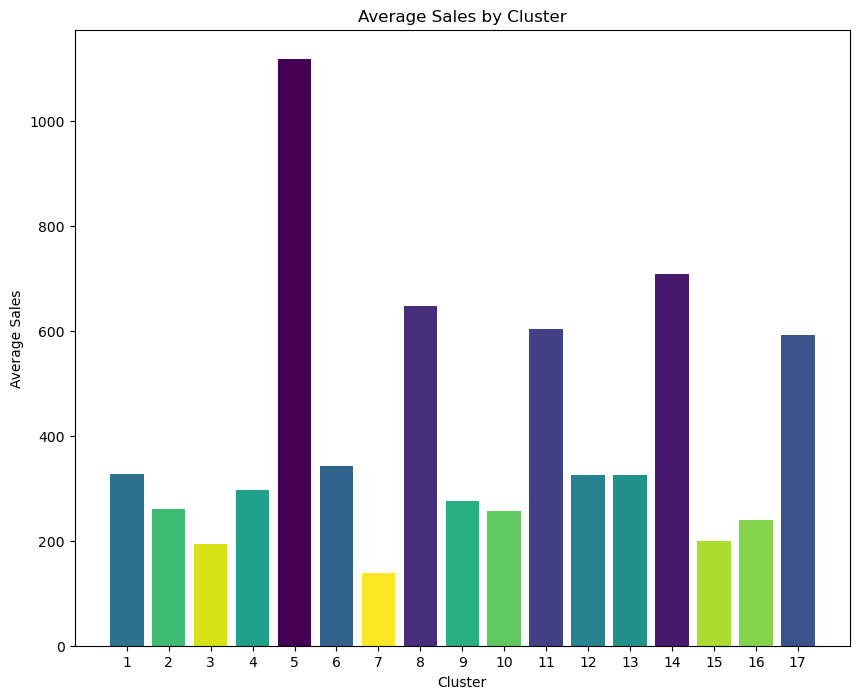

In [39]:
# Group by cluster and calculate the average sales and sort in descending order
average_sales_by_cluster = merged.groupby('cluster')['sales'].mean().sort_values(ascending=False)

# Set the number of bars in each plot
num_bars = len(average_sales_by_cluster)

# Generate the colors using the viridis palette
colors = plt.cm.viridis(np.linspace(0, 1, num_bars))

# Plot the average sales by cluster
plt.figure(figsize=(10, 8))
plt.bar(average_sales_by_cluster.index, average_sales_by_cluster.values, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Average Sales')
plt.title('Average Sales by Cluster')

# Set the x-tick labels as integers
plt.xticks(range(1, len(average_sales_by_cluster.index)+1))
plt.show()

In [40]:
from scipy import stats

# Group by date and cluster and calculates the sum of sales, then unstack cluster, having 1 column of sales for each cluster.
sum_sales_by_cluster = merged.loc[:, ['date', 'cluster', 'sales']].groupby(['date', 'cluster']).sum().unstack('cluster').fillna(0.)
list_sales_cluster = [sum_sales_by_cluster.iloc[:, cluster] for cluster in range(sum_sales_by_cluster.shape[1])]

# ANOVA
f_statistic, p_value = stats.f_oneway(
    list_sales_cluster[0],
    list_sales_cluster[1],
    list_sales_cluster[2],
    list_sales_cluster[3],
    list_sales_cluster[4],
    list_sales_cluster[5],
    list_sales_cluster[6],
    list_sales_cluster[7],
    list_sales_cluster[8],
    list_sales_cluster[9],
    list_sales_cluster[10],
    list_sales_cluster[11],
    list_sales_cluster[12],
    list_sales_cluster[13],
    list_sales_cluster[14],
    list_sales_cluster[15],
    list_sales_cluster[16],
)

# Print the test result
print("Hypothesis Testing for Cluster Sales:")
print("-" * 50)
print("F Statistic:", f_statistic)
print("P-value:", p_value)
print("=" * 50)
if p_value < 0.05:
    print("Reject the null hypothesis. Cluster have a significant impact on store sales.")
else:
    print("Fail to reject the null hypothesis. Cluster do not have a significant impact on store sales.")

Hypothesis Testing for Cluster Sales:
--------------------------------------------------
F Statistic: 2993.8388028317727
P-value: 0.0
Reject the null hypothesis. Cluster have a significant impact on store sales.


Just by analyzing the graph of average sales per cluster, we were already able to draw relevant information.

With the F-test we were able to confirm that the different clusters have different amounts of sales over time.

### 3.5. Do Product Families Behave Differently in Terms of Sales?
---

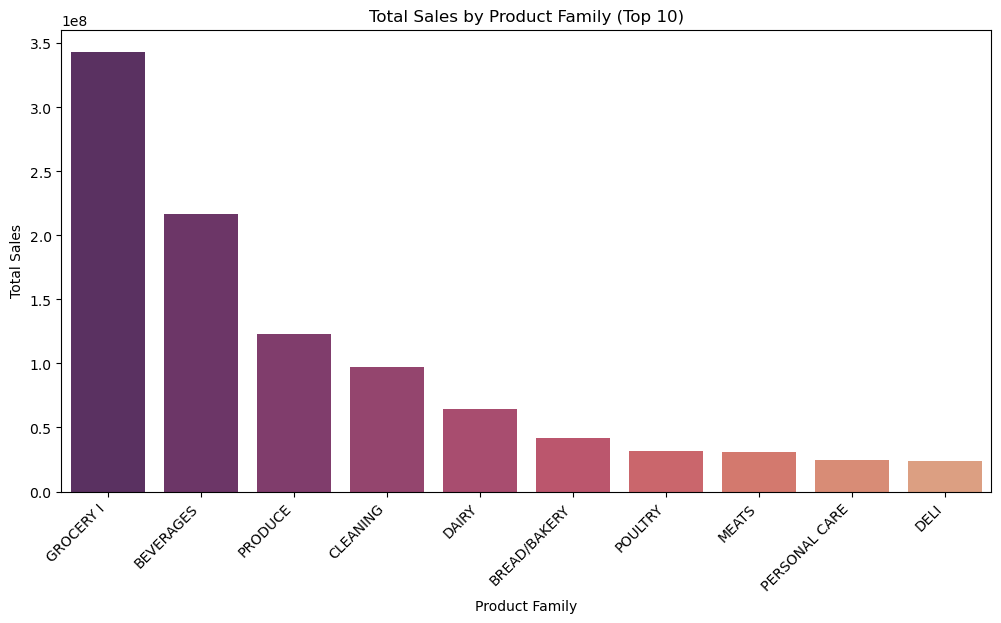

In [111]:
# Group the data by product family and calculate the total sales
family_sales = merged.groupby('family')['sales'].sum().sort_values(ascending=False)

# Select the top 10 product families
top_10_families = family_sales.head(10)

# Plot product family x sales for the top 10 families
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_families.index, y=top_10_families.values, palette='flare_r')
plt.xlabel('Product Family')
plt.ylabel('Total Sales')
plt.title('Total Sales by Product Family (Top 10)')
plt.xticks(rotation=45, ha='right')
plt.show()

As we can see above, there is a big difference in terms of sales between the product families.

### 3.6. Do Store Number ('store_nbr') Behave Differently in Terms of Sales?
---

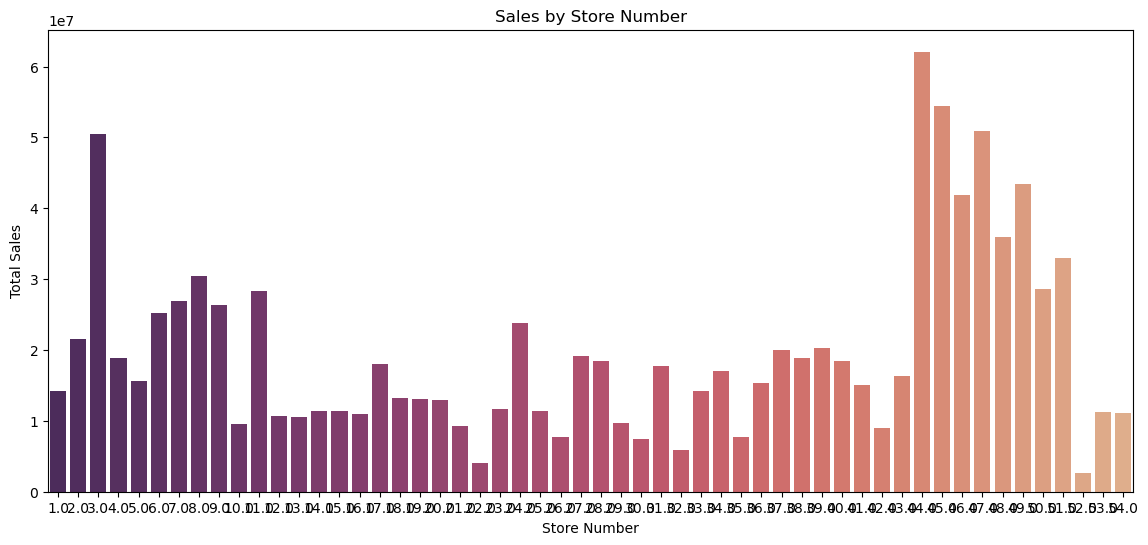

In [112]:
# Create a dataframe with the sum of sales for each store_nbr
store_sales = merged.groupby('store_nbr')['sales'].sum()

# Plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=store_sales.index, y=store_sales.values, palette='flare_r')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.title('Sales by Store Number')

plt.show()

As we can see above, there is a great difference in terms of sales between each store number ('store_nbr').

<br><br>

## 4. Feature Engineering

### 4.1. What Features Can We Extract From Date?
---

In this part, we will extract year, month and day from the date feature:

In [43]:
# Creating a copy of the merged dataframe
merged_copy = merged.copy()

# Extracting Date Parts
merged_copy['date'] = pd.to_datetime(merged_copy['date'])
merged_copy['year'] = merged_copy['date'].dt.year
merged_copy['month'] = merged_copy['date'].dt.month
merged_copy['day'] = merged_copy['date'].dt.day
merged_copy.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday,oil_price,year,month,day
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,0.0,1.0,93.14,2013,1,1
1,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,0.0,1.0,93.14,2013,1,1
2,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0,Quito,Pichincha,D,13,0.0,1.0,93.14,2013,1,1
3,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13,0.0,1.0,93.14,2013,1,1
4,4.0,2013-01-01,1.0,BOOKS,0.0,0.0,Quito,Pichincha,D,13,0.0,1.0,93.14,2013,1,1


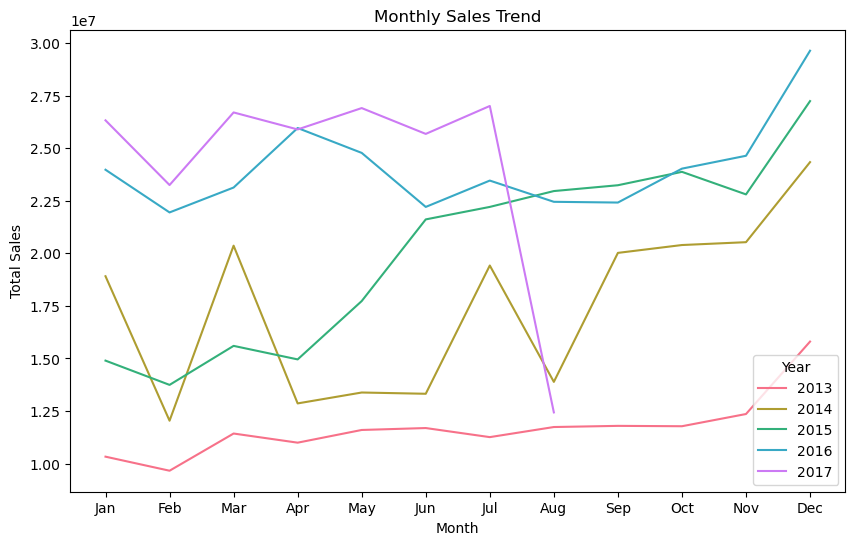

In [114]:
# Set distinct colors for each year
colors = sns.color_palette("husl", n_colors=len(merged_copy['year'].unique()))

months = ['Jan','Feb', 'Mar',
          'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep',
          'Oct', 'Nov', 'Dec']

# Visualize the Monthly Sales
monthly_sales = merged_copy.groupby(['year', 'month'])['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales, x='month', y='sales', hue='year', palette=colors)
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13), labels=months)
plt.legend(title='Year')
plt.show()

The line plot depicting the monthly sales shows variations in sales throughout the year.  
Sales seem to dip during the middle months of the year (July to September) before rising again in the last quarter (October to December), with the highest sales in December.  
The year-wise color distinction helps to observe sales patterns for each year.

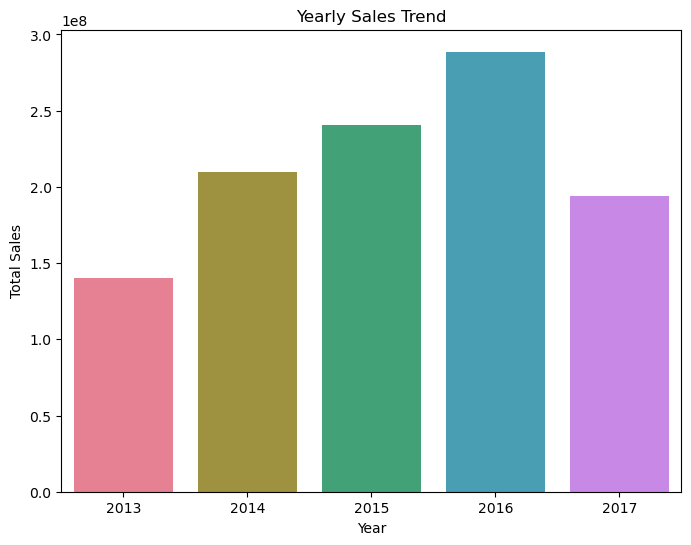

In [115]:
# Visualize the Yearly Sales Trend
yearly_sales = merged_copy.groupby('year')['sales'].sum().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(data=yearly_sales, x='year', y='sales', palette=colors)
plt.title('Yearly Sales Trend')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.show()

The bar plot shows the total sales for each year. As we can see, 2016 had the hightest sum of sales among the 5 years.

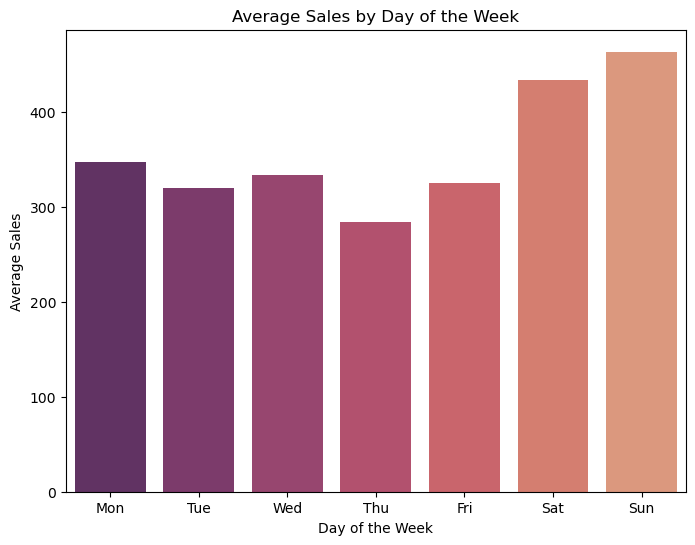

In [116]:
# Visualize the Day of the Week Sales Pattern
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

merged_copy['day_of_week'] = merged_copy['date'].dt.dayofweek
day_of_week_sales = merged_copy.groupby('day_of_week')['sales'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=day_of_week_sales, x='day_of_week', y='sales', palette='flare_r')
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.xticks(range(7), labels=days_of_week)
plt.show()

As we can see above, in Saturday and Sunday there is no sales, because the stores don't operate on weekend.

### 4.2. Mutual Information

#### 4.2.1. MI for Numerical Features
---

In [117]:
# # Separate target and features for Mutual Information
# X = merged_copy.drop('sales', axis=1).select_dtypes(include=numerical_dtypes)
# y = merged_copy['sales']

# # Fit the mutual_info_regression
# mi = mutual_info_regression(X, y, random_state=42)

# # Showing the results
# print("Mutual Information for Numeric Features:")
# print('---'*13, end="\n\n")
# for feature, value in zip(X.columns, mi):
#     print(f"{feature}: {value}")

'\n# Separate target and features for Mutual Information\nX = merged_copy.drop(\'sales\', axis=1).select_dtypes(include=numerical_dtypes)\ny = merged_copy[\'sales\']\n\n# Fit the mutual_info_regression\nmi = mutual_info_regression(X, y, random_state=42)\n\n# Showing the results\nprint("Mutual Information for Numeric Features:")\nprint(\'---\'*13, end="\n\n")\nfor feature, value in zip(X.columns, mi):\n    print(f"{feature}: {value}")\n'

In the numerical features there are two highlights:
*   `onpromotion`: MI ~0.212;
*   `transactions`: MI ~0.147;
*   `store_nbr`: MI ~0.134.

The `id` feature is a counter that goes from `0` to `len(n)-1`. It has no useful information for our dataset.

#### 4.2.2. MI for Categorical Features
---

In [118]:
# # Separate target and features for Mutual Information
# X = merged_copy.drop('sales', axis=1).select_dtypes(include=['category', 'object'])
# for non_cat in X.select_dtypes(include=['object']).columns:
#     X[non_cat] = X[non_cat].astype('category')

# y = merged_copy['sales']

# # Encode features with values between 0 and n_categories-1
# ord_enc = OrdinalEncoder()
# col_names = X.columns
# X = ord_enc.fit_transform(X)
# X = pd.DataFrame(data=X, columns=col_names)

# # Fit the mutual_info_regression
# mi = mutual_info_regression(X, y, random_state=42)

# # Showing the results
# print("Mutual Information for Categorical Features:")
# print('---'*13, end="\n\n")
# for feature, value in zip(X.columns, mi):
#     print(f"{feature}: {value}")

'\n# Separate target and features for Mutual Information\nX = merged_copy.drop(\'sales\', axis=1).select_dtypes(include=[\'category\', \'object\'])\nfor non_cat in X.select_dtypes(include=[\'object\']).columns:\n    X[non_cat] = X[non_cat].astype(\'category\')\n\ny = merged_copy[\'sales\']\n\n# Encode features with values between 0 and n_categories-1\nord_enc = OrdinalEncoder()\ncol_names = X.columns\nX = ord_enc.fit_transform(X)\nX = pd.DataFrame(data=X, columns=col_names)\n\n# Fit the mutual_info_regression\nmi = mutual_info_regression(X, y, random_state=42)\n\n# Showing the results\nprint("Mutual Information for Categorical Features:")\nprint(\'---\'*13, end="\n\n")\nfor feature, value in zip(X.columns, mi):\n    print(f"{feature}: {value}")\n'

As we can see above, the `family` feature has a very important impact on `sales` (target).

<br><br>

### 4.3. Scaling Features:

#### 4.3.1 StandardScaler
---
Standardize features by removing the mean and scaling to unit variance.

In [119]:
# # Create instance of StandardScaler
# std_scaler = StandardScaler()

# # Select Numerical features
# numerical_features = ['onpromotion', 'transactions', 'oil_price']

# # Fit the numerical columns and then Tranform them inplace
# merged_copy[numerical_features] = std_scaler.fit_transform(merged_copy[numerical_features])

# # Display the updated dataframe
# merged_copy.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday,oil_price,year,month,day,day_of_week
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,-0.213012,Quito,Pichincha,D,13,-1.505571,1.0,0.983412,2013,1,1,1
1,1.0,2013-01-01,1.0,BABY CARE,0.0,-0.213012,Quito,Pichincha,D,13,-1.505571,1.0,0.983412,2013,1,1,1
2,2.0,2013-01-01,1.0,BEAUTY,0.0,-0.213012,Quito,Pichincha,D,13,-1.505571,1.0,0.983412,2013,1,1,1
3,3.0,2013-01-01,1.0,BEVERAGES,0.0,-0.213012,Quito,Pichincha,D,13,-1.505571,1.0,0.983412,2013,1,1,1
4,4.0,2013-01-01,1.0,BOOKS,0.0,-0.213012,Quito,Pichincha,D,13,-1.505571,1.0,0.983412,2013,1,1,1


In this project we won't scale the target `sales`, because the metric used in the competition is **RMSLE**.  
Here is why:

*   **RMSLE is Scale-Invariant**:
    *   RMSLE naturally deals with differences in scale because it is based on the ratio between predicted and actual values (after taking the logarithm). This makes it scale-invariant, meaning it won't directly benefit from scaling the target variable.
    If you scale your target variable, the logarithmic transformation in RMSLE will simply reverse that scaling.

*   **Logarithmic Transformation**:
    *    The logarithmic function applied within RMSLE already compresses large ranges into a more manageable scale. Scaling the target before applying RMSLE might not have the intended effect because the log transformation already normalizes the differences.

*   **Interpretation Issues**:
    *   If you scale the target variable before calculating RMSLE, the resulting metric will no longer be directly interpretable in the original units. This can complicate the evaluation and comparison of your model.

<br><br>

### 4.4. Encoding Features:

#### 4.4.1. Drop Unneccessary Features:
---

In [44]:
# Selecting Unneccessary Features
columns_to_drop = ['date','id', 'store_type', 'state']

# Droping Features
merged_copy = merged_copy.drop(columns=columns_to_drop)

# Print first 5 rows
merged_copy.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday,oil_price,year,month,day
0,1.0,AUTOMOTIVE,0.0,0.0,Quito,13,0.0,1.0,93.14,2013,1,1
1,1.0,BABY CARE,0.0,0.0,Quito,13,0.0,1.0,93.14,2013,1,1
2,1.0,BEAUTY,0.0,0.0,Quito,13,0.0,1.0,93.14,2013,1,1
3,1.0,BEVERAGES,0.0,0.0,Quito,13,0.0,1.0,93.14,2013,1,1
4,1.0,BOOKS,0.0,0.0,Quito,13,0.0,1.0,93.14,2013,1,1


#### 4.4.2. Product Categorization Based on Families
---

In [121]:
# Get unique values of 'family' feature and print it
families = merged_copy['family'].unique()
families

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [122]:
# # Create groups based on similar families
# eletronic_families = ['PLAYERS AND ELECTRONICS','HARDWARE']
# clothing_families = ['LINGERIE', 'LADYSWARE']
# food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI','PRODUCE', 'DAIRY','POULTRY','EGGS','SEAFOOD']
# grocery_families = ['GROCERY I', 'GROCERY II']
# cleaning_families = ['HOME CARE', 'BABY CARE','PERSONAL CARE']
# home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
# stationery_families = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']


# # Categorize the 'family' feature based on the family groups
# merged_copy['family'] = np.where(merged_copy['family'].isin(food_families), 'FOODS', merged_copy['family'])
# merged_copy['family'] = np.where(merged_copy['family'].isin(home_families), 'HOME', merged_copy['family'])
# merged_copy['family'] = np.where(merged_copy['family'].isin(clothing_families), 'CLOTHING', merged_copy['family'])
# merged_copy['family'] = np.where(merged_copy['family'].isin(grocery_families), 'GROCERY', merged_copy['family'])
# merged_copy['family'] = np.where(merged_copy['family'].isin(stationery_families), 'STATIONERY', merged_copy['family'])
# merged_copy['family'] = np.where(merged_copy['family'].isin(cleaning_families), 'CLEANING', merged_copy['family'])
# merged_copy['family'] = np.where(merged_copy['family'].isin(eletronic_families), 'ELETRONICS', merged_copy['family'])

# # Print the updated DataFrame
# merged_copy.head(15)

In [123]:
families = merged_copy['family'].unique()
families

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

#### 4.4.3. OneHotEncoding Categorical Features:
---

In [70]:
def create_one_hot(df, cat_features):
    encoder = OneHotEncoder()
    one_hot_encoded_data = encoder.fit_transform(df[cat_features])

    # Create column names for the one-hot encoded data
    column_names = encoder.get_feature_names_out(cat_features)

    # Convert the one-hot encoded data to a DataFrame
    merged_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

    # Concatenate the original dataframe with the one-hot encoded data
    merged_encoded = pd.concat([df, merged_encoded], axis=1)

    # Drop the original categorical columns
    merged_encoded.drop(cat_features, axis=1, inplace=True)

    # Return the encoded DataFrame
    return merged_encoded

In [47]:
# Select categorical features
# categorical_features = merged_copy.select_dtypes(include=['category', 'object']).columns.to_list()
categorical_features = ["family", "city"]

# Perform one-hot encoding
encoder = OneHotEncoder()
one_hot_encoded_data = encoder.fit_transform(merged_copy[categorical_features])

# Create column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_features)

# Convert the one-hot encoded data to a DataFrame
merged_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original dataframe with the one-hot encoded data
merged_encoded = pd.concat([merged_copy, merged_encoded], axis=1)

# Drop the original categorical columns
merged_encoded.drop(categorical_features, axis=1, inplace=True)

# Print the head of the encoded DataFrame
merged_encoded.head()

,store_nbr,sales,onpromotion,cluster,transactions,holiday,oil_price,year,month,day,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
0,1.0,0.0,0.0,13,0.0,1.0,93.14,2013,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,13,0.0,1.0,93.14,2013,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,13,0.0,1.0,93.14,2013,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,13,0.0,1.0,93.14,2013,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,13,0.0,1.0,93.14,2013,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


With these, we can proceed to modeling!

<br><br>

## 5. Modeling

### 5.1. Train-Validation Split
---

Since we are dealing with time series, we can't shuffle our dataset because we have time dependency.  
For our project we will use:
*   years of `2013`, `2014`, `2015` and `2016` for **training**;
*   year of `2017` for **testing**.

In [73]:
# lag features
test = merged.copy()

for lag in [1, 7, 14, 21, 28]:
    test[f'lag_{lag}'] = test.groupby(['store_nbr', 'family'])['sales'].shift(lag)

test = create_one_hot(test, ["family", "city"])

test.head()

,id,date,store_nbr,sales,onpromotion,state,store_type,cluster,transactions,holiday,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
0,0.0,2013-01-01,1.0,0.0,0.0,Pichincha,D,13,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,2013-01-01,1.0,0.0,0.0,Pichincha,D,13,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2.0,2013-01-01,1.0,0.0,0.0,Pichincha,D,13,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3.0,2013-01-01,1.0,0.0,0.0,Pichincha,D,13,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4.0,2013-01-01,1.0,0.0,0.0,Pichincha,D,13,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### 5.1.1 Using Last Year as Validation Set:
---

In [126]:
# Split merged_encoded in train and validation
train_set = merged_encoded.loc[merged_encoded['year'].isin([2013, 2014, 2015, 2016])]
val_set = merged_encoded.loc[merged_encoded['year'] == 2017]

# Separate X, y for training
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales'] 

# Separate X, y for validation
X_val = val_set.drop('sales', axis=1)  
y_val = val_set['sales']

### 5.1.2 Using Only last 15 days as Validation Set (Equal to the test size):
---

In [75]:
last_15_days = test['date'].unique()[-15:]
validation_mask = test['date'].isin(last_15_days)

train_set = test[~validation_mask]
val_set = test[validation_mask]

# Separate X, y for training
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales'] 

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Separate X, y for validation
X_val = val_set.drop('sales', axis=1)  
y_val = val_set['sales']

### 5.2. Model 1: Linear Regression
---

In [127]:
# Linear Regression Model
model_1 = LinearRegression()
model_1.fit(X_train, y_train)
model_1_predictions = model_1.predict(X_val).clip(0.)

# Calculate metrics
model_1_mse = mean_squared_error(y_val, model_1_predictions)
model_1_mae = mean_absolute_error(y_val, model_1_predictions)

# Apply the absolute value function to both y_val and model_1_predictions
y_val_abs = abs(y_val)
model_1_predictions_abs = abs(model_1_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
model_1_rmsle = np.sqrt(mean_squared_log_error(y_val_abs, model_1_predictions_abs))

# Create a DataFrame to store results for Linear Regression
results_model_1 = pd.DataFrame({'Model': ['Linear Regression'],
                            'RMSLE': [model_1_rmsle],
                            'RMSE': [np.sqrt(model_1_mse)],
                            'MSE': [model_1_mse],
                            'MAE': [model_1_mae]}).round(2)

# Print the results_model_1 dataframe
results_model_1

,Model,RMSLE,RMSE,MSE,MAE
0,Linear Regression,2.06,828.8,686905.36,295.98


In [128]:
coefficients = model_1.coef_

# Step 3: Calculate feature importance
importance = np.abs(coefficients)

# Optional: Sort features by importance
feature_names = [str(name) for name in X_train.columns]
sorted_indices = np.argsort(importance)[::-1]
sorted_feature_names = np.array(feature_names)[sorted_indices]
sorted_importance = importance[sorted_indices]

# Print feature importance
for feature, imp in zip(sorted_feature_names, sorted_importance):
    print(f"{feature}: {imp:.4f}")

family_BOOKS: 952914476334.6947
family_BABY CARE: 952914476334.6741
family_HOME APPLIANCES: 952914476334.3247
family_SCHOOL AND OFFICE SUPPLIES: 952914476334.2605
family_HARDWARE: 952914476333.6929
family_BEAUTY: 952914476332.5023
family_MAGAZINES: 952914476332.4288
family_PET SUPPLIES: 952914476332.0212
family_LAWN AND GARDEN: 952914476331.4111
family_PLAYERS AND ELECTRONICS: 952914476329.6232
family_AUTOMOTIVE: 952914476329.3761
family_LADIESWEAR: 952914476328.5376
family_CELEBRATION: 952914476328.4458
family_LINGERIE: 952914476327.8879
family_HOME AND KITCHEN II: 952914476323.6959
family_HOME AND KITCHEN I: 952914476319.2083
family_SEAFOOD: 952914476319.1687
family_GROCERY II: 952914476314.6741
family_LIQUOR,WINE,BEER: 952914476254.9673
family_PREPARED FOODS: 952914476244.6882
family_EGGS: 952914476199.0115
family_HOME CARE: 952914476197.6094
family_FROZEN FOODS: 952914476196.3204
family_DELI: 952914476167.4326
family_PERSONAL CARE: 952914476102.6530
family_MEATS: 952914476045.8883
